In [155]:
# The question: How many deaths can be predicted by vaccination rates?
# The strategy: regress death rates onto last weeks and the current weeks vaccination rates
# Result - L1 estimate: 200k deaths. Confidence interval [50k, 500k].
# Data source: CDC (see README.md)
library("ggplot2")
library("dplyr")
library("tidyr")
library(MMWRweek)
library(quantreg)
library("lubridate")

In [156]:
# Make a convenience function that transforms state codes to state names

#'x' is the column of a data.frame that holds 2 digit state codes
stateFromLower <-function(x) {
   #read 52 state codes into local variable [includes DC (Washington D.C. and PR (Puerto Rico)]
  st.codes<-data.frame(
                      state=as.factor(c("AK", "AL", "AR", "AZ", "CA", "CO", "CT", "DC", "DE", "FL", "GA",
                                         "HI", "IA", "ID", "IL", "IN", "KS", "KY", "LA", "MA", "MD", "ME",
                                         "MI", "MN", "MO", "MS",  "MT", "NC", "ND", "NE", "NH", "NJ", "NM",
                                         "NV", "NY", "OH", "OK", "OR", "PA", "PR", "RI", "SC", "SD", "TN",
                                         "TX", "UT", "VA", "VT", "WA", "WI", "WV", "WY")),
                      full=as.factor(c("alaska","alabama","arkansas","arizona","california","colorado",
                                       "connecticut","district of columbia","delaware","florida","georgia",
                                       "hawaii","iowa","idaho","illinois","indiana","kansas","kentucky",
                                       "louisiana","massachusetts","maryland","maine","michigan","minnesota",
                                       "missouri","mississippi","montana","north carolina","north dakota",
                                       "nebraska","new hampshire","new jersey","new mexico","nevada",
                                       "new york","ohio","oklahoma","oregon","pennsylvania","puerto rico",
                                       "rhode island","south carolina","south dakota","tennessee","texas",
                                       "utah","virginia","vermont","washington","wisconsin",
                                       "west virginia","wyoming"))
                       )
     #create an nx1 data.frame of state codes from source column
  st.x<-data.frame(state=x)
     #match source codes with codes from 'st.codes' local variable and use to return the full state name
  refac.x<-st.codes$full[match(st.x$state,st.codes$state)]
     #return the full state names in the same order in which they appeared in the original source
  return(refac.x)
 
}

In [157]:
# Read death data. Deaths are centered by weekly median from 2014-2019 after a linear trend is 
# removed based on the same time period (see the notebook named "statewide")
deaths = read.csv("../data/state_centered.csv")
deaths$Week.Ending.Date = ymd(deaths$Week.Ending.Date)
head(deaths)

,X,State,detrended,median,Week.Ending.Date,Total.Deaths,data_set,MMWR.Week,centered
,<int>,<chr>,<dbl>,<dbl>,<date>,<int>,<chr>,<int>,<dbl>
1,1,Alabama,1057.0000,1067.139,2014-01-04,1057,2014-2019,1,-10.139241
2,2,Alabama,1076.7215,1081.361,2014-01-11,1077,2014-2019,2,-4.639241
3,3,Alabama,1047.4430,1034.222,2014-01-18,1048,2014-2019,3,13.221519
4,4,Alabama,1021.1646,1005.544,2014-01-25,1022,2014-2019,4,15.620253
5,5,Alabama,1039.8861,1056.266,2014-02-01,1041,2014-2019,5,-16.379747
6,6,Alabama,990.6076,1035.886,2014-02-08,992,2014-2019,6,-45.278481


In [158]:
# Take in raw vaccination data from the CDC
us_vacc = read.csv("../data/COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv")
us_vacc$Date = mdy(us_vacc$Date)
us_vacc$year = year(us_vacc$Date)
colnames(us_vacc)

[1] "Date"                                  
 [2] "MMWR_week"                             
 [3] "Location"                              
 [4] "Distributed"                           
 [5] "Distributed_Janssen"                   
 [6] "Distributed_Moderna"                   
 [7] "Distributed_Pfizer"                    
 [8] "Distributed_Unk_Manuf"                 
 [9] "Dist_Per_100K"                         
[10] "Distributed_Per_100k_12Plus"           
[11] "Distributed_Per_100k_18Plus"           
[12] "Distributed_Per_100k_65Plus"           
[13] "Administered"                          
[14] "Administered_12Plus"                   
[15] "Administered_18Plus"                   
[16] "Administered_65Plus"                   
[17] "Administered_Janssen"                  
[18] "Administered_Moderna"                  
[19] "Administered_Pfizer"                   
[20] "Administered_Unk_Manuf"                
[21] "Admin_Per_100K"                        
[22] "Admin_Per_100k_12Plus"                 
[23] "Admin_Per_100k_18Plus"                 
[24] "Admin_Per_100k_65Plus"                 
[25] "Recip_Administered"                    
[26] "Administered_Dose1_Recip"              
[27] "Administered_Dose1_Pop_Pct"            
[28] "Administered_Dose1_Recip_12Plus"       
[29] "Administered_Dose1_Recip_12PlusPop_Pct"
[30] "Administered_Dose1_Recip_18Plus"       
[31] "Administered_Dose1_Recip_18PlusPop_Pct"
[32] "Administered_Dose1_Recip_65Plus"       
[33] "Administered_Dose1_Recip_65PlusPop_Pct"
[34] "Series_Complete_Yes"                   
[35] "Series_Complete_Pop_Pct"               
[36] "Series_Complete_12Plus"                
[37] "Series_Complete_12PlusPop_Pct"         
[38] "Series_Complete_18Plus"                
[39] "Series_Complete_18PlusPop_Pct"         
[40] "Series_Complete_65Plus"                
[41] "Series_Complete_65PlusPop_Pct"         
[42] "Series_Complete_Janssen"               
[43] "Series_Complete_Moderna"               
[44] "Series_Complete_Pfizer"                
[45] "Series_Complete_Unk_Manuf"             
[46] "Series_Complete_Janssen_12Plus"        
[47] "Series_Complete_Moderna_12Plus"        
[48] "Series_Complete_Pfizer_12Plus"         
[49] "Series_Complete_Unk_Manuf_12Plus"      
[50] "Series_Complete_Janssen_18Plus"        
[51] "Series_Complete_Moderna_18Plus"        
[52] "Series_Complete_Pfizer_18Plus"         
[53] "Series_Complete_Unk_Manuf_18Plus"      
[54] "Series_Complete_Janssen_65Plus"        
[55] "Series_Complete_Moderna_65Plus"        
[56] "Series_Complete_Pfizer_65Plus"         
[57] "Series_Complete_Unk_Manuf_65Plus"      
[58] "Additional_Doses"                      
[59] "Additional_Doses_Vax_Pct"              
[60] "Additional_Doses_18Plus"               
[61] "Additional_Doses_18Plus_Vax_Pct"       
[62] "Additional_Doses_50Plus"               
[63] "Additional_Doses_50Plus_Vax_Pct"       
[64] "Additional_Doses_65Plus"               
[65] "Additional_Doses_65Plus_Vax_Pct"       
[66] "Additional_Doses_Moderna"              
[67] "Additional_Doses_Pfizer"               
[68] "Additional_Doses_Janssen"              
[69] "Additional_Doses_Unk_Manuf"            
[70] "Administered_Dose1_Recip_5Plus"        
[71] "Administered_Dose1_Recip_5PlusPop_Pct" 
[72] "Series_Complete_5Plus"                 
[73] "Series_Complete_5PlusPop_Pct"          
[74] "Administered_5Plus"                    
[75] "Admin_Per_100k_5Plus"                  
[76] "Distributed_Per_100k_5Plus"            
[77] "Series_Complete_Moderna_5Plus"         
[78] "Series_Complete_Pfizer_5Plus"          
[79] "Series_Complete_Janssen_5Plus"         
[80] "Series_Complete_Unk_Manuf_5Plus"       
[81] "year"

In [174]:
# Group by week and state and sum total vaccinated
vacc_weekly = us_vacc %>% group_by(MMWR_week, year, Location) %>% summarise(
    Administered_12Plus = sum(Administered_12Plus),
    Admin_Per_100k_12Plus = sum(Admin_Per_100k_12Plus),
    Administered = sum(Administered),
    Admin_Per_100K = sum(Admin_Per_100K),
    Date = max(Date))
vacc_weekly$State = stateFromLower(vacc_weekly$Location)
vacc_weekly = vacc_weekly[!is.na(vacc_weekly$State),]
head(vacc_weekly)                                                           
                                                                            

`summarise()` has grouped output by 'MMWR_week', 'year'. You can override using the `.groups` argument.



MMWR_week,year,Location,Administered_12Plus,Admin_Per_100k_12Plus,Administered,Admin_Per_100K,Date,State
<int>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<int>,<date>,<fct>
0,2022,AK,1998934,328298,2052994,280638,2022-01-02,alaska
0,2022,AL,11198202,267460,11310632,230680,2022-01-02,alabama
0,2022,AR,7465318,291928,7600836,251866,2022-01-02,arkansas
0,2022,AZ,20624566,332330,21053178,289242,2022-01-02,arizona
0,2022,CA,129119104,383754,132464330,335248,2022-01-02,california
0,2022,CO,18545650,375718,19095446,331590,2022-01-02,colorado


In [257]:
# Compute predictors, in this case last week's and the current week's vaccination rates
vacc_weekly$d_Administered_12Plus = 0 
vacc_weekly$d_Administered = 0 
vacc_weekly$d_Admin_Per_100K = 0 
vacc_weekly$d_Admin_Per_100k_12Plus = 0 
vacc_weekly$l_Administered_12Plus = 0 
vacc_weekly$l_Administered = 0 
vacc_weekly$l_Admin_Per_100K = 0 
vacc_weekly$l_Admin_Per_100k_12Plus = 0 
vacc_weekly$l2_Administered = 0 

for (state in unique(vacc_weekly$Location)) {
    sorted = vacc_weekly[order(vacc_weekly$Date),]
    sorted = subset(sorted, Location == state)
    n = dim(sorted)[1]
    sorted$d_Administered_12Plus = c(0, diff(sorted$Administered_12Plus))
    sorted$d_Administered = c(0, diff(sorted$Administered))
    sorted$d_Admin_Per_100K = c(0, diff(sorted$Admin_Per_100K))
    sorted$d_Admin_Per_100k_12Plus = c(0, diff(sorted$Admin_Per_100k_12Plus))
    sorted$l_Administered_12Plus = c(diff(sorted$Administered_12Plus), 0)
    sorted$l_Administered = c(diff(sorted$Administered), 0)
    sorted$l2_Administered = c(diff(sorted$Administered)[2:(n-1)], 0, 0)
    sorted$l_Admin_Per_100K = c(diff(sorted$Admin_Per_100K), 0)
    sorted$l_Admin_Per_100k_12Plus = c(diff(sorted$Admin_Per_100k_12Plus), 0)

    vacc_weekly[vacc_weekly$Location == state, ] = sorted
}
vacc_weekly = vacc_weekly[vacc_weekly$Date < ymd("2021-12-15"),]
vacc_weekly = vacc_weekly[vacc_weekly$l2_Administered >= 0,]
head(vacc_weekly)

MMWR_week,year,Location,Administered_12Plus,Admin_Per_100k_12Plus,Administered,Admin_Per_100K,Date,State,d_Administered_12Plus,d_Administered,d_Admin_Per_100K,d_Admin_Per_100k_12Plus,l_Administered_12Plus,l_Administered,l_Admin_Per_100K,l_Admin_Per_100k_12Plus,l2_Administered
<int>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<int>,<date>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52,2020,AK,0,0,52418,7167,2020-12-26,alaska,0,0,0,0,0,9893,1350,0,89397
52,2020,AL,0,0,77155,1574,2020-12-26,alabama,0,0,0,0,0,27295,557,0,230290
52,2020,AR,0,0,116924,3875,2020-12-26,arkansas,0,0,0,0,0,24746,819,0,144483
52,2020,AZ,0,0,95414,1310,2020-12-26,arizona,0,0,0,0,0,72435,996,0,413896
52,2020,CA,0,0,977339,2474,2020-12-26,california,0,0,0,0,0,428491,1085,0,2185483
52,2020,CO,0,0,289001,5019,2020-12-26,colorado,0,0,0,0,0,63920,1109,0,549453


In [276]:
sum_deaths = deaths %>% group_by(State) %>% summarize(sum=sum(Total.Deaths))
big_states = tail(sum_deaths[order(sum_deaths$sum),], 7)$State # US is one of these
small_states = head(sum_deaths[order(sum_deaths$sum),], 7)$State

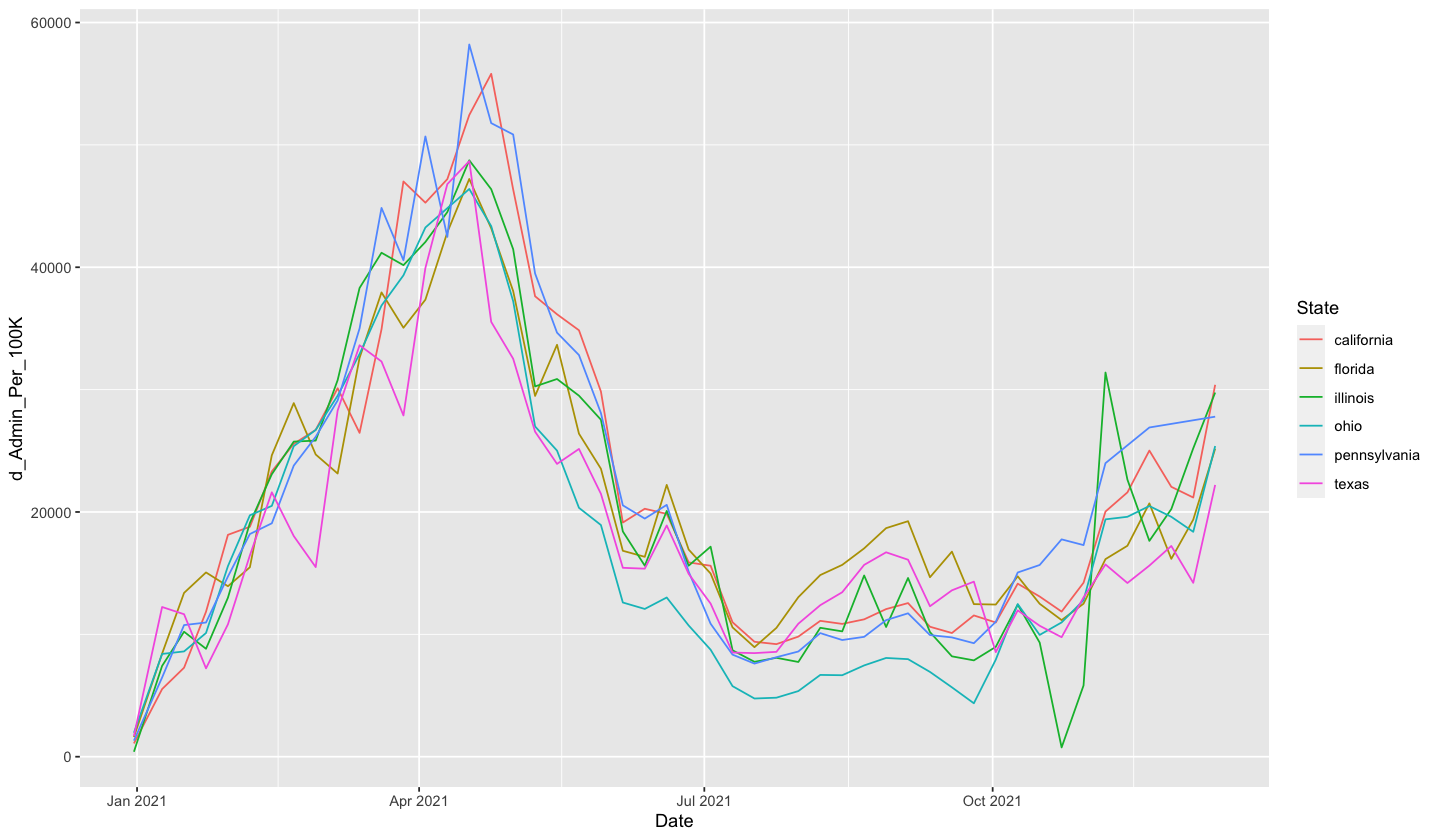

In [277]:
# Plot vaccination rates in select states and remove negative rates (not possible)
vacc_weekly$State = stateFromLower(vacc_weekly$Location)
vacc_weekly = vacc_weekly[vacc_weekly$d_Administered > 0,]
a = ggplot(vacc_weekly[vacc_weekly$State %in% big_states,], aes(x=Date, y=d_Admin_Per_100K, color=State))
a + geom_line()

In [278]:
deaths$State = tolower(deaths$State)
deaths$Date = deaths$Week.Ending.Date
vacc_weekly$State = stateFromLower(vacc_weekly$Location)
df = merge(deaths, vacc_weekly, by = c("Date", "State"))

In [279]:
# Fit a regression with just lag 2 (weeks before death)
lmfit = lm(centered ~ l2_Administered + l_Administered + d_Administered - 1, data=df)
rqfit = rq(centered ~ l2_Administered + l_Administered + d_Administered - 1, data=df)
summary(lmfit)
summary(rqfit)


Call:
lm(formula = centered ~ l2_Administered + l_Administered + d_Administered - 
    1, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-1973.6   -33.5    18.5   105.8  5320.3 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
l2_Administered  1.018e-04  1.200e-05   8.482   <2e-16 ***
l_Administered  -4.172e-06  1.580e-05  -0.264    0.792    
d_Administered  -1.217e-05  1.191e-05  -1.022    0.307    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 365.4 on 2525 degrees of freedom
Multiple R-squared:  0.2318,	Adjusted R-squared:  0.2309 
F-statistic:   254 on 3 and 2525 DF,  p-value: < 2.2e-16


Warning message in summary.rq(rqfit):
“69 non-positive fis”



Call: rq(formula = centered ~ l2_Administered + l_Administered + d_Administered - 
    1, data = df)

tau: [1] 0.5

Coefficients:
                Value   Std. Error t value Pr(>|t|)
l2_Administered 0.00005 0.00001    4.45658 0.00001 
l_Administered  0.00000 0.00001    0.07747 0.93826 
d_Administered  0.00001 0.00001    0.68380 0.49417 

In [280]:
lmfit = lm(centered ~ l2_Administered - 1, data=df)
rqfit = rq(centered ~ l2_Administered - 1, data=df)
rqfit_low = rq(centered ~ l2_Administered - 1, data=df, tau=0.25)
rqfit_high = rq(centered ~ l2_Administered - 1, data=df, tau=0.75)
summary(lmfit)
summary(rqfit)
summary(rqfit_low)


Call:
lm(formula = centered ~ l2_Administered - 1, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-1945.8   -34.2    18.3   104.3  5354.1 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
l2_Administered 8.632e-05  3.133e-06   27.55   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 365.5 on 2527 degrees of freedom
Multiple R-squared:  0.231,	Adjusted R-squared:  0.2307 
F-statistic: 759.3 on 1 and 2527 DF,  p-value: < 2.2e-16


Warning message in summary.rq(rqfit):
“103 non-positive fis”



Call: rq(formula = centered ~ l2_Administered - 1, data = df)

tau: [1] 0.5

Coefficients:
                Value    Std. Error t value  Pr(>|t|)
l2_Administered  0.00006  0.00000   12.47563  0.00000

Warning message in summary.rq(rqfit_low):
“103 non-positive fis”



Call: rq(formula = centered ~ l2_Administered - 1, tau = 0.25, data = df)

tau: [1] 0.25

Coefficients:
                Value   Std. Error t value Pr(>|t|)
l2_Administered 0.00002 0.00000    8.13852 0.00000 

In [281]:
df$death_estimate = lmfit$fit
df$robust_death_estimate = rqfit$fit
df$robust_death_estimate_low = rqfit_low$fit
df$robust_death_estimate_high = rqfit_high$fit
df$residuals = lmfit$residuals

In [282]:

pivot = pivot_longer(df, c("Total.Deaths", "death_estimate"), values_to = "Deaths", names_to="Type")
head(pivot)

Date,State,X,detrended,median,Week.Ending.Date,data_set,MMWR.Week,centered,MMWR_week,⋯,l_Administered,l_Admin_Per_100K,l_Admin_Per_100k_12Plus,l2_Administered,robust_death_estimate,robust_death_estimate_low,robust_death_estimate_high,residuals,Type,Deaths
<date>,<chr>,<int>,<dbl>,<dbl>,<date>,<chr>,<int>,<dbl>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2021-01-02,idaho,5370,304.41985,250.64885,2021-01-02,2020-2021,53,53.77099,53,⋯,120377,6736,0,138836,8.612379,2.248673,24.44607,41.78685062,Total.Deaths,349.00000
2021-01-02,idaho,5370,304.41985,250.64885,2021-01-02,2020-2021,53,53.77099,53,⋯,120377,6736,0,138836,8.612379,2.248673,24.44607,41.78685062,death_estimate,11.98414
2021-01-09,alabama,367,1707.07595,1067.13924,2021-01-09,2020-2021,1,639.93671,1,⋯,286446,5842,0,489167,30.344376,7.922847,86.13191,597.71245387,Total.Deaths,1809.00000
2021-01-09,alabama,367,1707.07595,1067.13924,2021-01-09,2020-2021,1,639.93671,1,⋯,286446,5842,0,489167,30.344376,7.922847,86.13191,597.71245387,death_estimate,42.22425
2021-01-09,alaska,784,97.87603,79.43802,2021-01-09,2020-2021,1,18.43802,1,⋯,136928,18717,0,212503,13.182146,3.441828,37.41726,0.09503579,Total.Deaths,113.00000
2021-01-09,alaska,784,97.87603,79.43802,2021-01-09,2020-2021,1,18.43802,1,⋯,136928,18717,0,212503,13.182146,3.441828,37.41726,0.09503579,death_estimate,18.34298


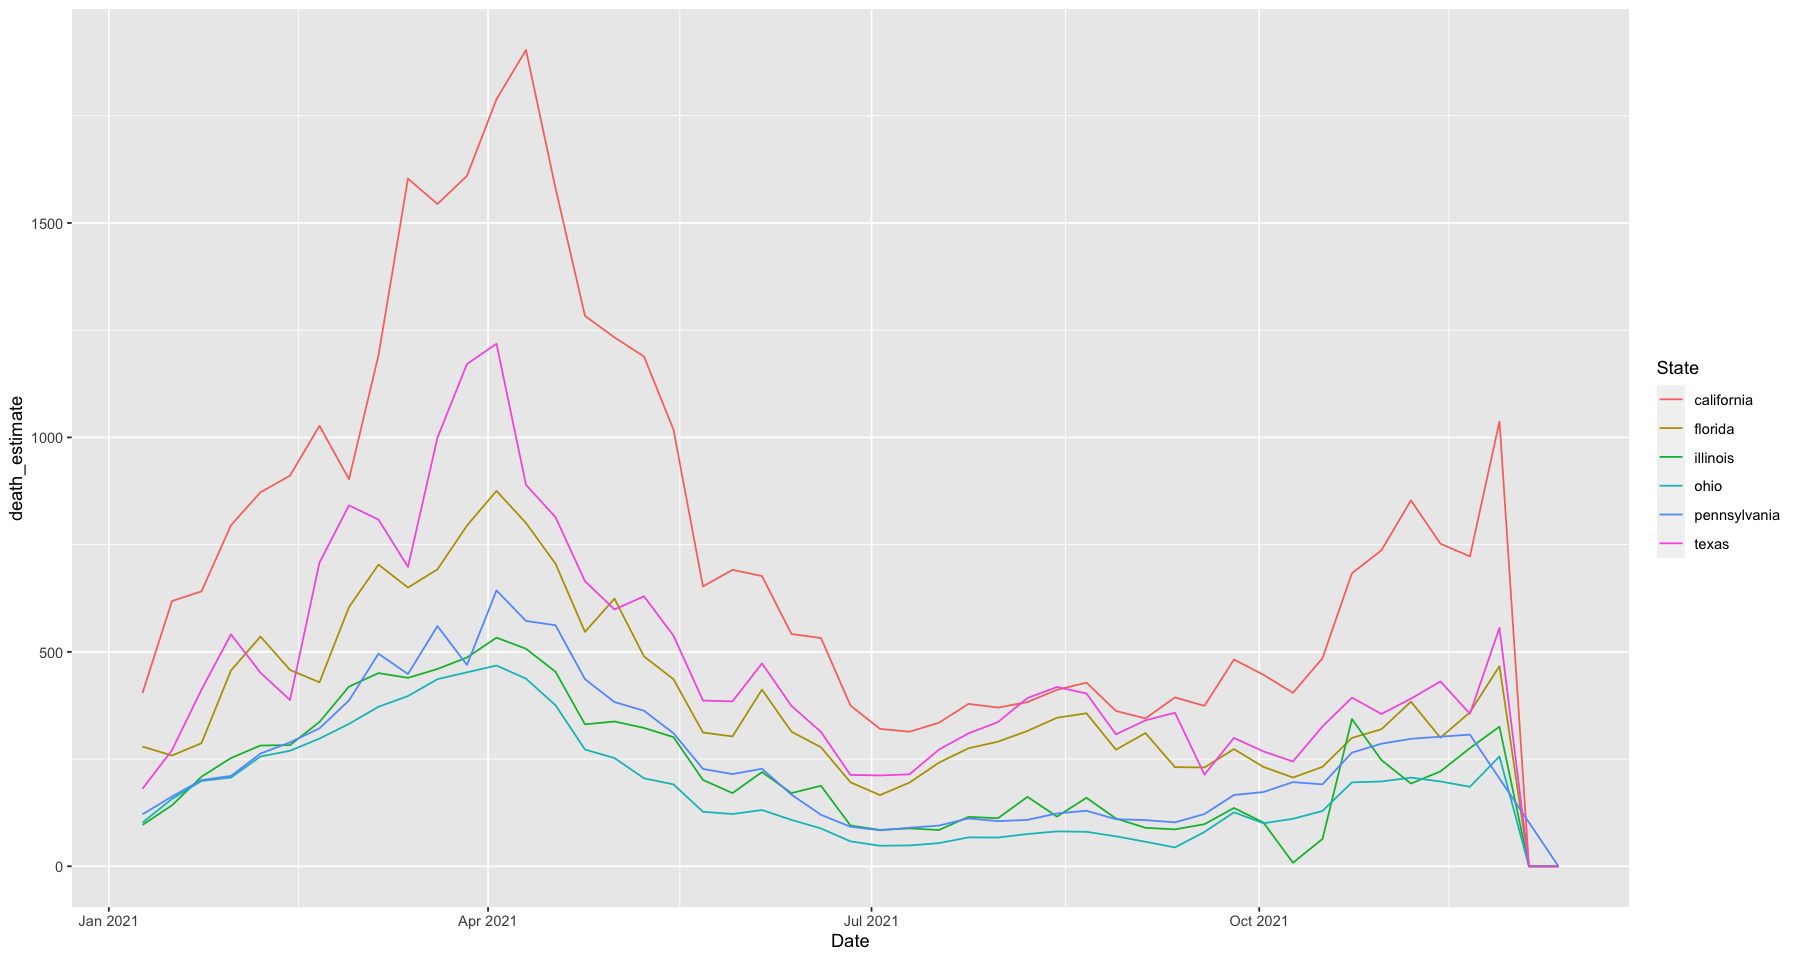

In [289]:
options(repr.plot.width=15, repr.plot.height=8)
c = ggplot(subset(df, State %in% big_states), aes(Date, death_estimate, color=State))
c + geom_line()

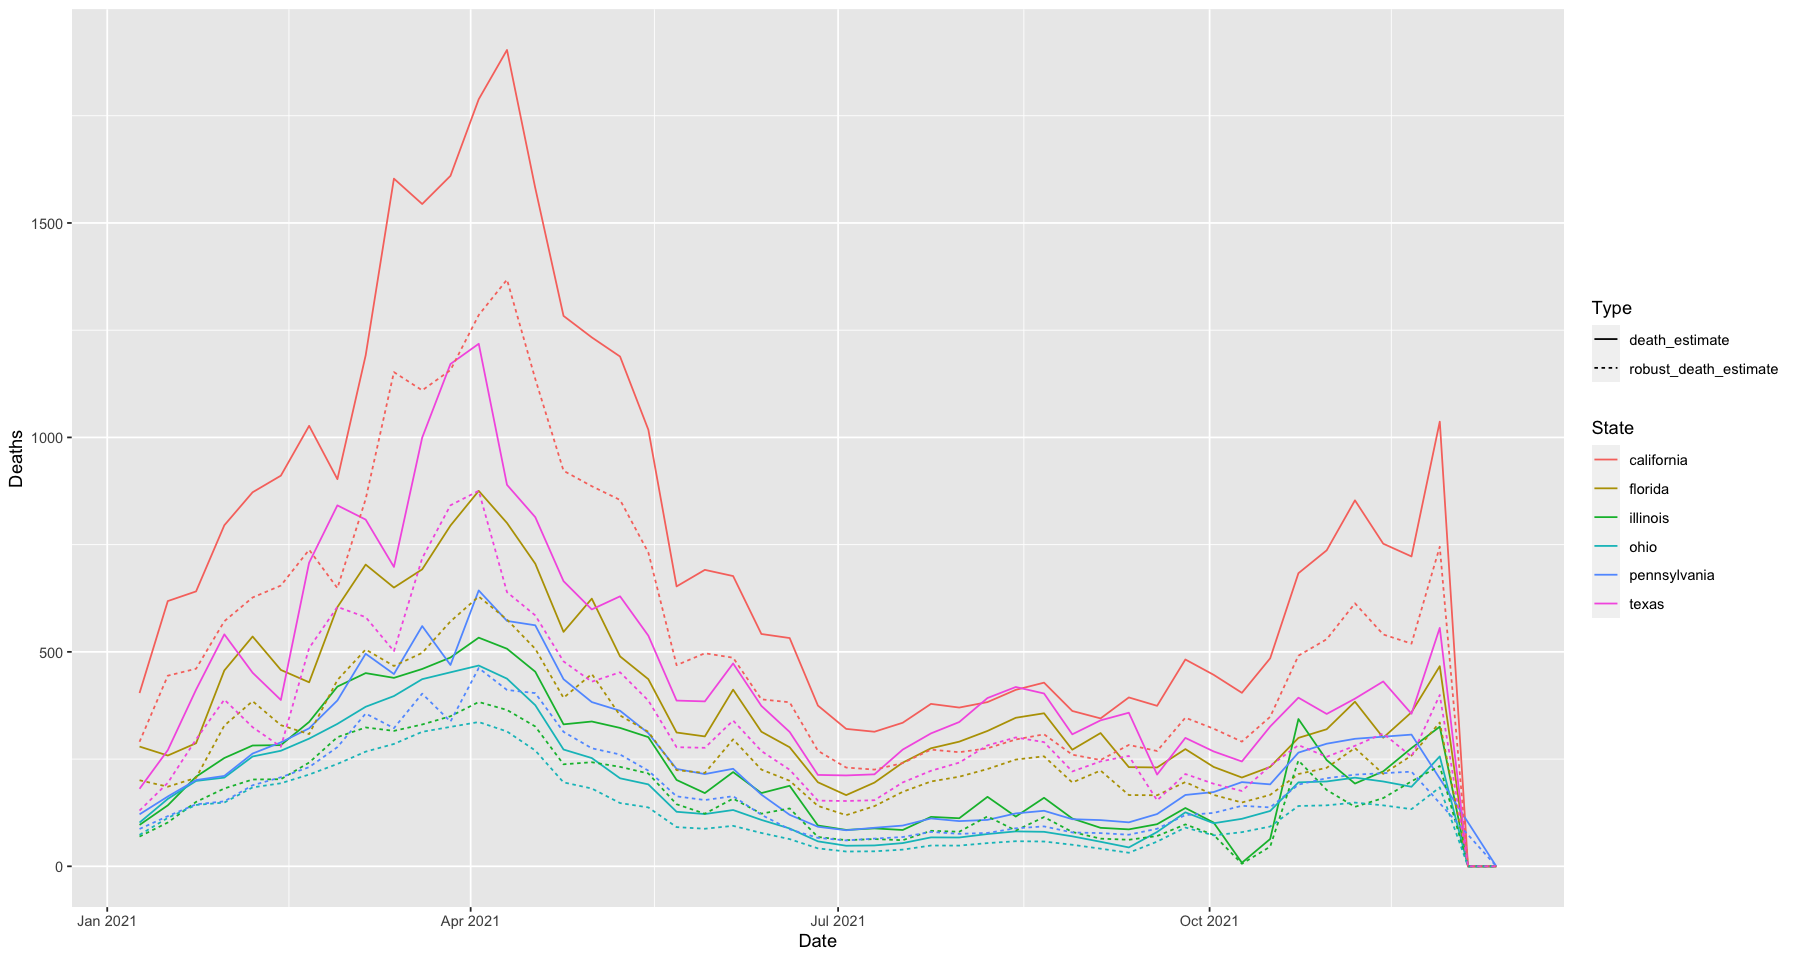

In [290]:
# Compare L1 with L2 fits in big states
pivot = pivot_longer(df, c("robust_death_estimate", "death_estimate"), values_to = "Deaths", names_to="Type")
c = ggplot(subset(pivot, State %in% big_states), aes(Date, Deaths, color=State))
c + geom_line(aes(linetype=Type))

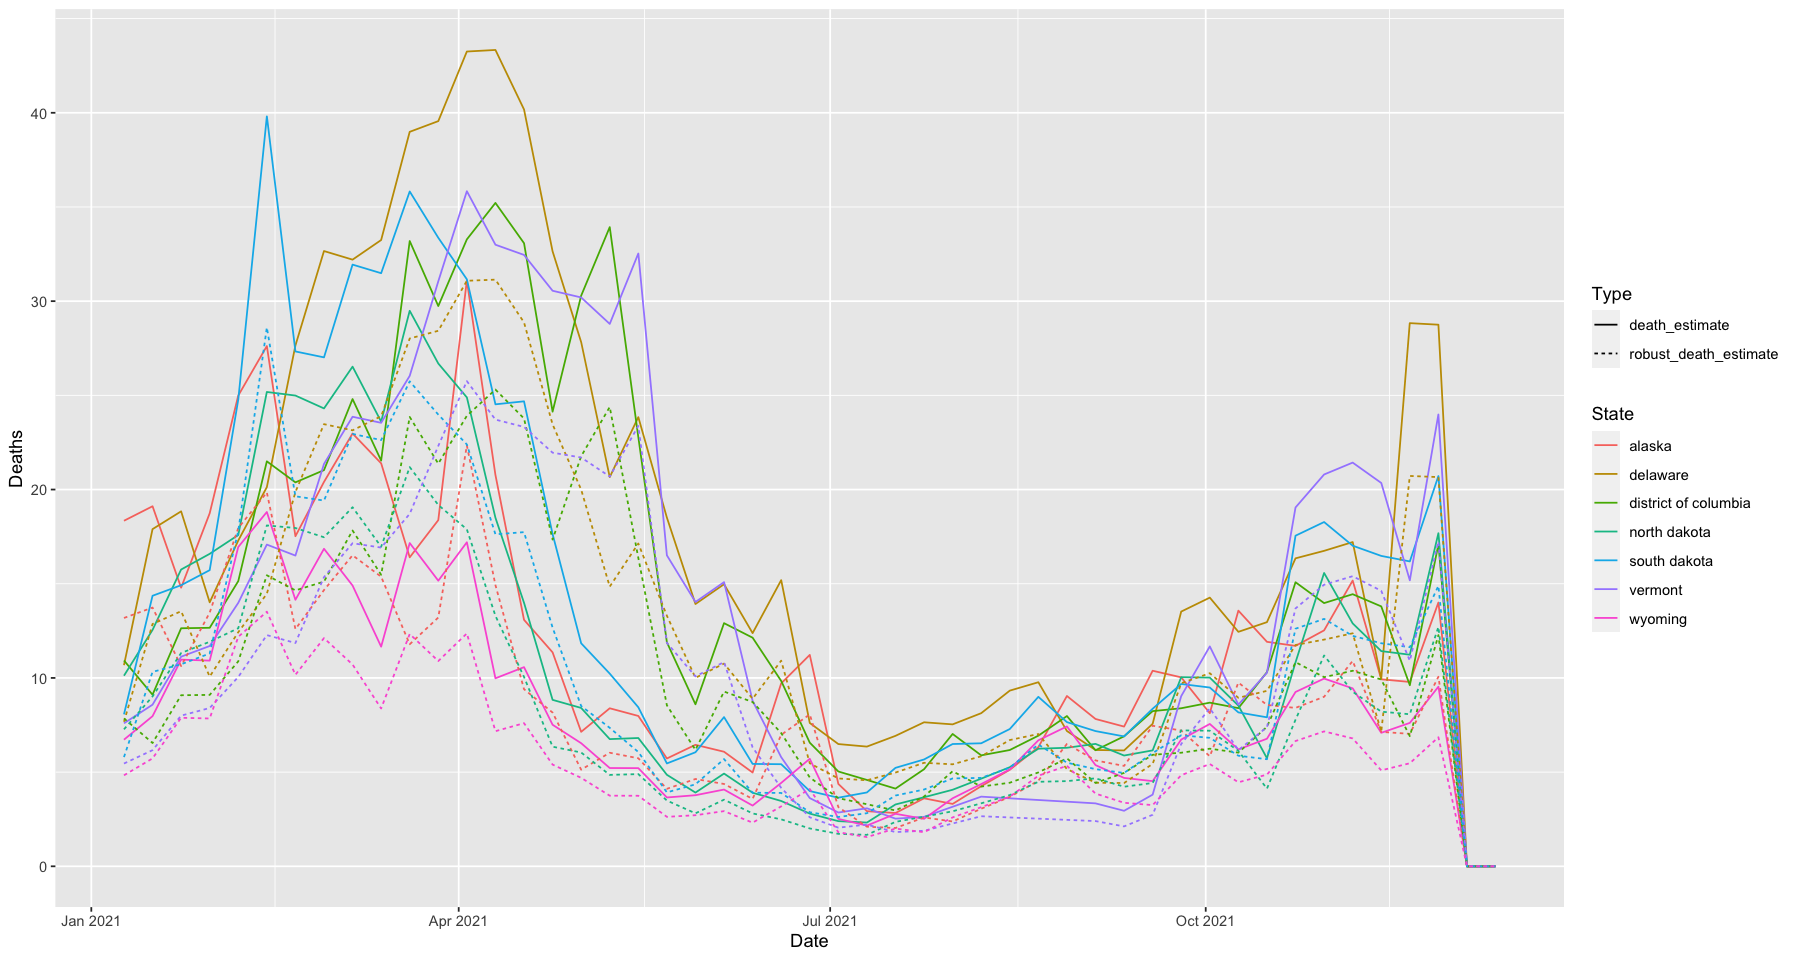

In [291]:
# Compare L1 with L2 fits in small states
pivot = pivot_longer(df, c("robust_death_estimate", "death_estimate"), values_to = "Deaths", names_to="Type")
c = ggplot(subset(pivot, State %in% small_states), aes(Date, Deaths, color=State))
c + geom_line(aes(linetype=Type))

In [292]:
print(paste("Overall estimated # of deaths from vacc week before: (L2-norm) ", round(sum(lmfit$fit))))
print(paste("Overall estimated # of deaths from vacc week before: (L1-norm) ", round(sum(rqfit$fit))))
print(sprintf("25th and 75th quantile (Interquartile range): [%d, %d]", 
            round(sum(rqfit_low$fit)),
            round(sum(rqfit_high$fit))))
# print(paste("Overall estimated # of deaths from vacc week before: (L1-norm) ", round(sum(rqfit$fit))))

[1] "Overall estimated # of deaths from vacc week before: (L2-norm)  279284"
[1] "Overall estimated # of deaths from vacc week before: (L1-norm)  200707"
[1] "25th and 75th quantile (Interquartile range): [52404, 569703]"


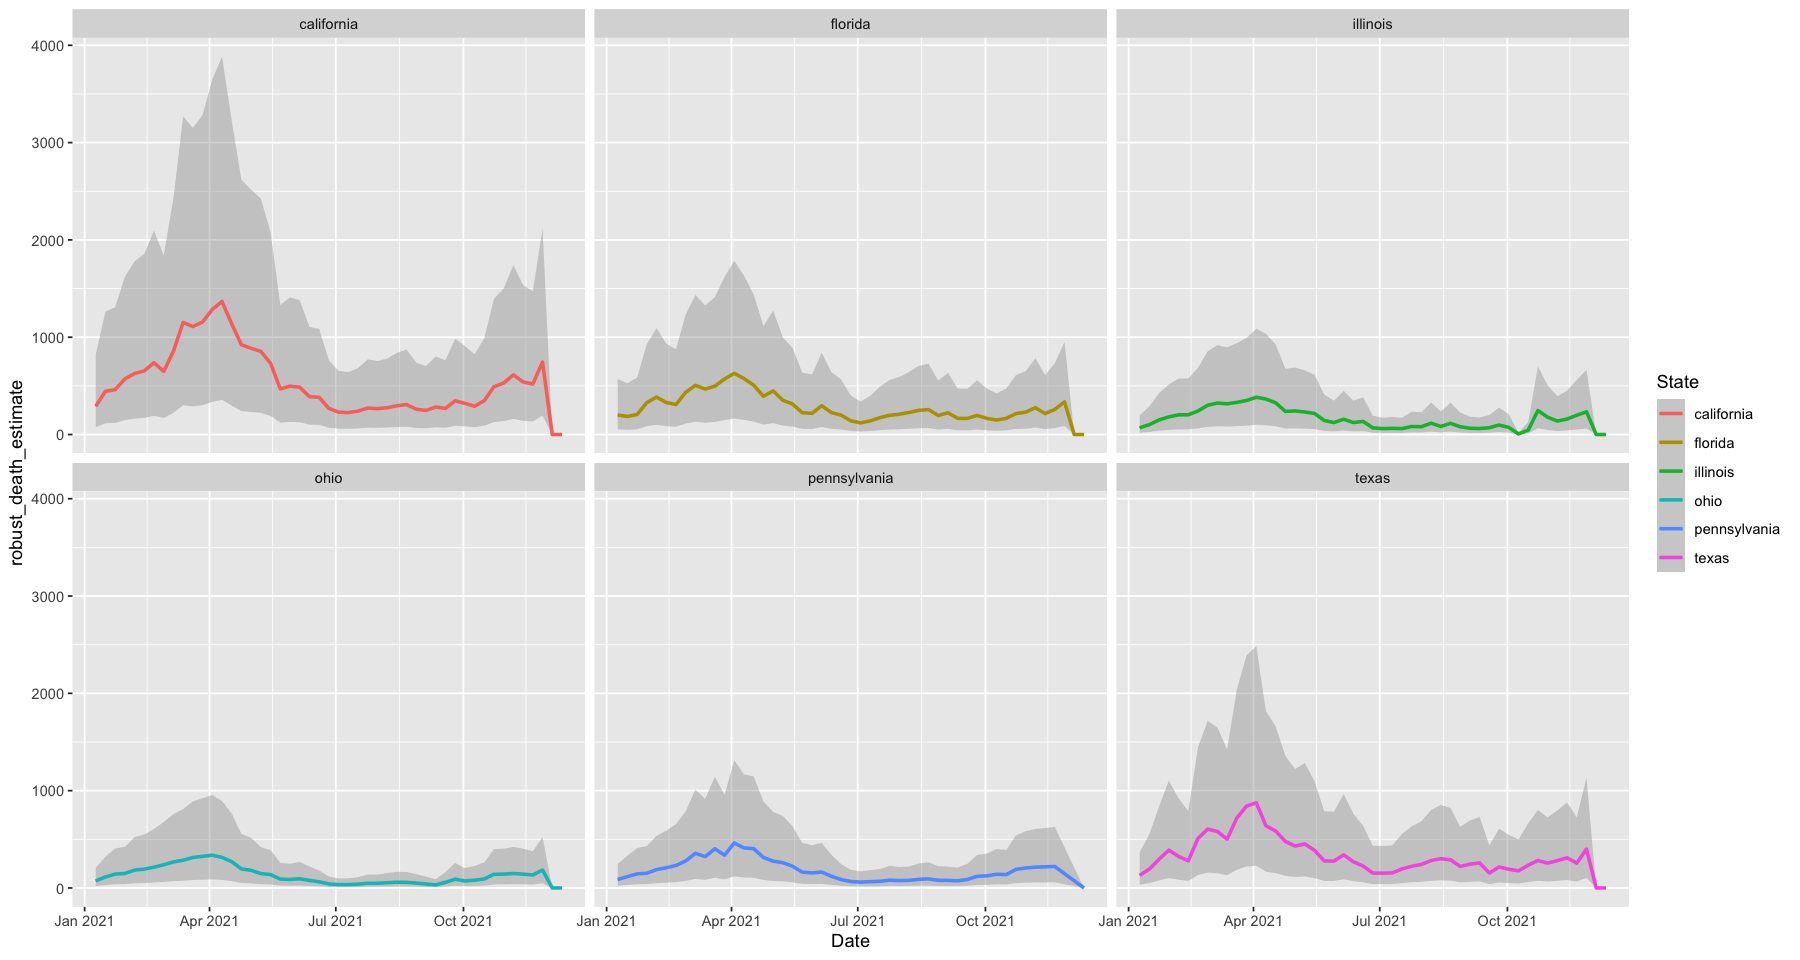

In [293]:
c = ggplot(subset(df, State %in% c(big_states)), aes(
    Date, robust_death_estimate, color=State, ymin= robust_death_estimate_low, ymax=robust_death_estimate_high))
c + geom_line() + geom_smooth(stat="identity") + facet_wrap(~State)

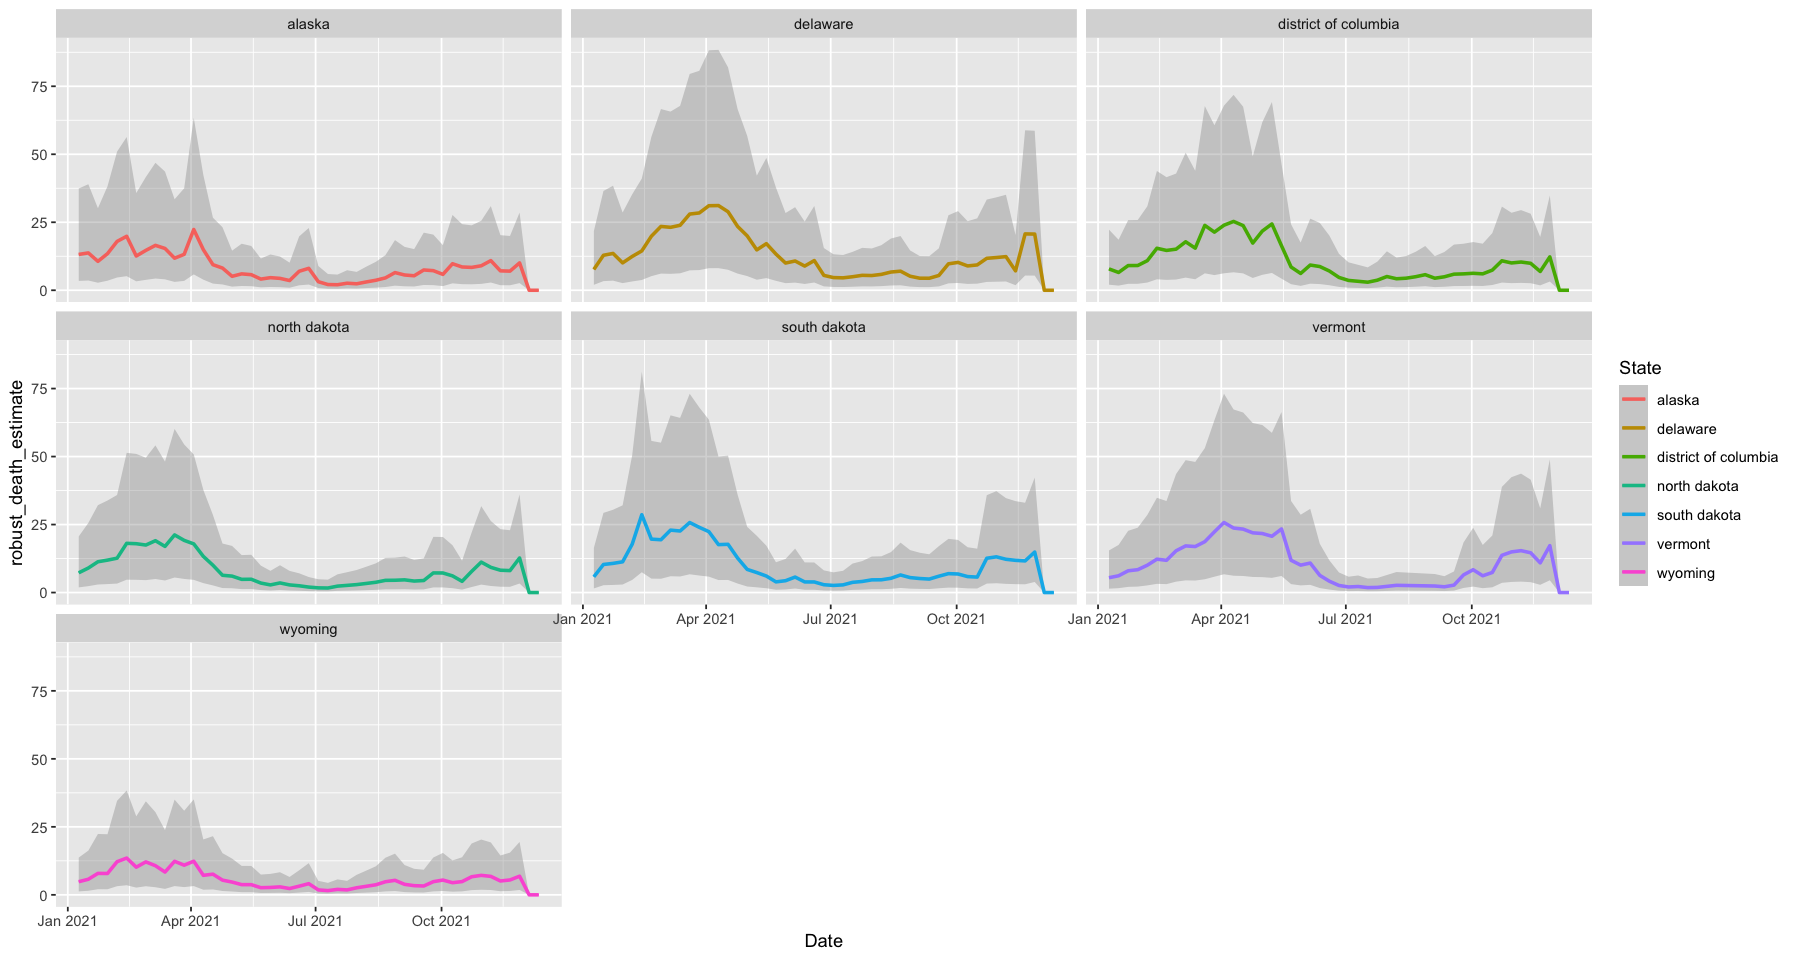

In [294]:
c = ggplot(subset(df, State %in% c(small_states)), aes(
    Date, robust_death_estimate, color=State, ymin= robust_death_estimate_low, ymax=robust_death_estimate_high))
c + geom_line() + geom_smooth(stat="identity") + facet_wrap(~State)